In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd /content/drive/MyDrive

/content/drive/MyDrive


In [3]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
import torch.optim as optim
from torch.optim import lr_scheduler
import os
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
from tqdm import tqdm_notebook

In [4]:
# !unzip archive.zip

In [5]:
mean = np.array([0.5, 0.5, 0.5])
std = np.array([0.25, 0.25, .25])

In [6]:
#   Set hyperparameters
batch_size = 4

In [7]:
data_transforms = {'train': transforms.Compose([transforms.RandomResizedCrop(224),
                                                transforms.RandomHorizontalFlip(),
                                                transforms.ToTensor(),
                                                transforms.Normalize(mean, std)]),
                                                
                    'val': transforms.Compose([transforms.Resize(256),
                                               transforms.CenterCrop(224),
                                               transforms.ToTensor(),
                                               transforms.Normalize(mean, std)])}        

In [8]:
base_path = '/content/drive/MyDrive'
data_path = os.path.join(base_path, 'hymenoptera_data')
print('Check directory is available => ', os.path.isdir(data_path))

Check directory is available =>  True


In [9]:
dataset = {x: datasets.ImageFolder(root = os.path.join(data_path, x), transform = data_transforms[x])
                                   for x in ('train', 'val')}

data_loader = {x: DataLoader(dataset = dataset[x], batch_size = batch_size, shuffle = True) 
                                   for x in ('train', 'val')}

In [10]:
data_size = {x: dataset[x] for x in ('train', 'val')}
class_names = dataset['train'].classes

In [11]:
#   Set device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

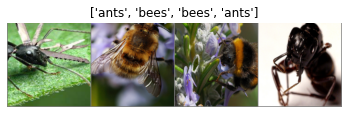

In [12]:
def imshow(inp, title):
    inp = inp.numpy().transpose((1, 2, 0))
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.title(title)
    plt.axis('off')
    plt.show()


# Get a batch of training data
inputs, classes = next(iter(data_loader['train']))

# # Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [13]:
def save_checkpoint(checkpoint):
    print('=> Saving checkpoint')
    torch.save(checkpoint, 'best_model.pth')

In [27]:
def train_model(model, loss_func, optimizer, scheduler, epoch):
    acc_train = 0
    loss_train = []
    acc_val = 0
    loss_val = []
    num_samples = 0
    for phase in ('train', 'val'):
        if phase == 'train':
            model.train()
        else:
            model.eval()
            
        #   Iterate over data
        for (data, label) in data_loader[phase]:
            data = data.to(device)
            label = label.to(device)

            with torch.set_grad_enabled(phase == 'train'):
                Y_pred  = model(data)
                loss = loss_func(Y_pred, label)
                num_samples += Y_pred.shape[0]
                if phase == 'train':
                    #   Calculate acc
                    _, max_idx = torch.max(Y_pred, dim = 1)
                    acc_train += (max_idx == label).sum()
                    #   Calculate loss
                    loss_train.append(loss.item())

                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                else:
                    #   Calculate acc
                    _, max_idx = torch.max(Y_pred, dim = 1)
                    acc_val += (max_idx == label).sum()
                    #   Calculate loss
                    loss_val.append(loss.item())


        if phase == 'train':
            #   Learning_rate scheduler
            scheduler.step()
                
            #   Save checkpoint model  every 5 epoches
            # if epoch % 5 == 0:
            #     checkpoint = {'state_dict': model.state_dict(), 'optim': optimizer.state_dict()}
            #     save_checkpoint(checkpoint)
    return acc_train/num_samples, np.mean(loss_train), acc_val/num_samples, np.mean(loss_val)

In [28]:
#   https://github.com/yusugomori/deeplearning-pytorch/blob/master/models/layers/GlobalAvgPool2d.py
class GlobalAvgPool2d(nn.Module):
    def __init__(self):
        super(GlobalAvgPool2d, self).__init__()

    def forward(self, x):
        return F.avg_pool2d(x, kernel_size = x.shape[2:]).reshape(x.shape[0], -1)

In [29]:
vgg_model = models.vgg16(pretrained = True)

#   Freeze convNet layer when training
for param in vgg_model.parameters():
    param.requires_grad = False

vgg_model.avgpool = GlobalAvgPool2d()
vgg_model.classifier = nn.Sequential(nn.Linear(512, 128),
                                 nn.ReLU(),
                                 nn.Dropout(0.5),
                                 nn.Linear(128, 2))
vgg_model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [30]:
num_epochs = 20
learning_rate = 0.003
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(params = vgg_model.parameters(), lr = learning_rate)
lr_schedule = lr_scheduler.StepLR(optimizer = optimizer, step_size = 7, gamma = 0.3)

In [ ]:
history = defaultdict(list)
best_acc = 0

for epoch in tqdm_notebook(range(num_epochs)):

    print(f'Epoch {epoch + 1}/{num_epochs}[=============================]')

    acc_train, loss_train, acc_val, loss_val = train_model(vgg_model, loss_func, optimizer, lr_schedule, epoch)
    print(f'Train: - Loss {loss_train}     - Accuracy {acc_train}')
    print(f'Val  : - Loss {loss_val}      - Accuracy {acc_val}\n')

    history['train_acc'].append(acc_train)
    history['train_loss'].append(loss_train)
    history['val_acc'].append(acc_val)
    history['val_loss'].append(loss_val)

    if acc_val > best_acc:
        torch.save(vgg_model.state_dict(), 'best_model.pth')
        best_acc = acc_val